<h2>Sentiment Analysis with Hugging Face</h2>

Natural Language Processing (<b>NLP</b>) is the crossover of linguistic and machine learning focused  on understad human languages.</br>
This aim is concretely classified in various task such as:
<ul>
    <li>Generating text content from a prompt.</li>
    <li>Producing an answer from a question in text form given the context.</li>
    <li>Translating/summarizing a text.</li>
    <li>Identifying words according to their grammatical or entity value.</li>
    <li>Getting the "sentiment" of a text.</li>
</ul>
In this project we implement a ML model to evaluate the overall sentiment ('positive' or 'negative') of Imdb movie reviews.</br>
A class of NLP models, dubbed Large Language Models (<b>LLMs</b>) are gaining more and more interest and popularity due to their capabilities; they're large-scale models, having $\simeq 10^{6}-10^{11}$ parameters which can learn by examples, perform multiple tasks and provide unexpected functionalities.</br>
Models this large makes the training step resource/time intensive, besides having a large environmental impact, this led to a novel approach for model training  through a process of transfer learning and fine tuning.</br>
In summary, instead of build a model from scratch one can use a pre-trained <it>language models</it> i.e. model trained on a large amount of unlabelled raw text from a specific language, such a model isn't the best performing for a specific task, but it has already a statistical understanding of a language and can be fine tuned with way less data and resources, we'll make use of the <b>Hugging Face</b> transform which has a vast collection ofrepositories for pre-trained model, usually called <it>transformers</it>.

In [ ]:
#!pip install tensorflow
#!pip install tf-keras
#!pip install transformers
!pip install datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve
from datasets import load_dataset
import tensorflow as tf
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

We first load the Imdb dataset and inspect the first few rows:

In [ ]:
dataset_id = 'imdb'
dataset = load_dataset(dataset_id)
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
for df_name in ['train', 'test', 'unsupervised']:
    print(df_name.upper())
    display(pd.DataFrame({'text' : dataset[df_name][:5]['text'], 'label' : dataset[df_name][:5]['label']}))
    print('\n')

TRAIN


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0




TEST


,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0




UNSUPERVISED


,text,label
0,This is just a precious little diamond. The pl...,-1
1,When I say this is my favourite film of all ti...,-1
2,I saw this movie because I am a huge fan of th...,-1
3,Being that the only foreign films I usually li...,-1
4,After seeing Point of No Return (a great movie...,-1


<h2>Transformes</h2>

Tranformers were introduce in mid 2017, initially for translation task but soon encompassing a many onthers which led to different, more specialized architectures; however they're all made of the combination of two blocks:</br>
<ul>
    <li>Encoder: it's the block responsible of <it>understanding</it> the input text by building a representation of it.</li>
    <li>Decoder: it's the block responsible of <it>generating</it> an output text using the encoder output and other inputs.</li>
</ul>
Some transformers are encoder-only since require only to understand the input, for example for classification, NER or sentimental analysis (BERT, the architecture we'll use is such a model); decoder-only models are suitable for text generation and encoder-decoder models, also called sequence-to-sequence are tipically used for text generation based on an input, such as summarization or translation.

<h3>Tokenizer</h3>

The tranformer library provide a pipeline function that let you set up and run a NLP model with maximum ease of use, leaving all the details under the hood, in this project we'll instead explore each block of the transformer, starting with the <it>tokenizer</it>.</br>
A tokenizer is a program that:
<ul>
    <li>Convert words in the text input into base words, subwords and symbols call tokens.</li>
    <li>Map each token to its ID, an integer.</li>
    <li>Output the ID's with additional information that may be used by the rest of a pipeline.</li>
</ul>
To initialize a tokenizer we load a <it>checkpoint</it>, i.e. a collection of weights of a pre-trained tokenizer:

In [ ]:
model_id = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
dataset['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

The result of the tokenization, shown below, is a list of string; words and punctuation symbols are isolated, also note that certain token are preceded by a double hash (##), this means they're the result of subword tokenization and actually are only part of larger words:

In [ ]:
sample_input = dataset['train']['text'][0]#[dataset['train']['text'][0], dataset['train']['text'][1]]
tokenizer.tokenize(sample_input)

['i',
 'rented',
 'i',
 'am',
 'curious',
 '-',
 'yellow',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967',
 '.',
 'i',
 'also',
 'heard',
 'that',
 'at',
 'first',
 'it',
 'was',
 'seized',
 'by',
 'u',
 '.',
 's',
 '.',
 'customs',
 'if',
 'it',
 'ever',
 'tried',
 'to',
 'enter',
 'this',
 'country',
 ',',
 'therefore',
 'being',
 'a',
 'fan',
 'of',
 'films',
 'considered',
 '"',
 'controversial',
 '"',
 'i',
 'really',
 'had',
 'to',
 'see',
 'this',
 'for',
 'myself',
 '.',
 '<',
 'br',
 '/',
 '>',
 '<',
 'br',
 '/',
 '>',
 'the',
 'plot',
 'is',
 'centered',
 'around',
 'a',
 'young',
 'swedish',
 'drama',
 'student',
 'named',
 'lena',
 'who',
 'wants',
 'to',
 'learn',
 'everything',
 'she',
 'can',
 'about',
 'life',
 '.',
 'in',
 'particular',
 'she',
 'wants',
 'to',
 'focus',
 'her',
 'attention',
 '##s',
 'to',
 'making',
 'some',
 'sort',
 '

The tokens can then be converted to their ids with the <it>convert_tokens_to_ids()</it> method, in this case we just call the tokenizer to do the tokenization and the conversion in a single step.</br>
Note that the padding and the truncation parameter are unnecessary for one text input, we just include them for good practice: padding uniforms the length of each text by adding padding token as necessary, the <it>attention mask</it> tensor keeps track of which token are (sub)word (1) and should be attended or just padding (0) and to be ignored.

In [ ]:
sample_output = tokenizer(sample_input, padding = True, truncation = True)
display(sample_output)

{'input_ids': [101, 1045, 12524, 1045, 2572, 8025, 1011, 3756, 2013, 2026, 2678, 3573, 2138, 1997, 2035, 1996, 6704, 2008, 5129, 2009, 2043, 2009, 2001, 2034, 2207, 1999, 3476, 1012, 1045, 2036, 2657, 2008, 2012, 2034, 2009, 2001, 8243, 2011, 1057, 1012, 1055, 1012, 8205, 2065, 2009, 2412, 2699, 2000, 4607, 2023, 2406, 1010, 3568, 2108, 1037, 5470, 1997, 3152, 2641, 1000, 6801, 1000, 1045, 2428, 2018, 2000, 2156, 2023, 2005, 2870, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 5436, 2003, 8857, 2105, 1037, 2402, 4467, 3689, 3076, 2315, 14229, 2040, 4122, 2000, 4553, 2673, 2016, 2064, 2055, 2166, 1012, 1999, 3327, 2016, 4122, 2000, 3579, 2014, 3086, 2015, 2000, 2437, 2070, 4066, 1997, 4516, 2006, 2054, 1996, 2779, 25430, 14728, 2245, 2055, 3056, 2576, 3314, 2107, 2004, 1996, 5148, 2162, 1998, 2679, 3314, 1999, 1996, 2142, 2163, 1012, 1999, 2090, 4851, 8801, 1998, 6623, 7939, 4697, 3619, 1997, 8947, 2055, 2037, 10740, 2006, 4331, 1010, 2016, 2038, 3348, 2007, 2014, 3689, 383

The decode methods convert the tokens ids list back to text by using the tokenizer vocabulary, note how the text is uncased according to the checkpoint loaded:

In [ ]:
tokenizer.decode(sample_output['input_ids'])

'[CLS] i rented i am curious - yellow from my video store because of all the controversy that surrounded it when it was first released in 1967. i also heard that at first it was seized by u. s. customs if it ever tried to enter this country, therefore being a fan of films considered " controversial " i really had to see this for myself. < br / > < br / > the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life. in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. < br / > < br / > what kills me about i am curious - yellow is that 40 years ago, this was considered pornographic. really, the sex and nudity scenes 

We map the tokenization to the entire datasets:

In [ ]:
def tokenize_function(x):
    return tokenizer(x['text'], padding =  True, truncation = True)

dataset_tokenized = dataset.map(tokenize_function, batched = True)
dataset_tokenized

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [ ]:
display(pd.DataFrame(dataset_tokenized['train'][:5]))

,text,label,input_ids,token_type_ids,attention_mask
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,"[101, 1045, 12524, 1045, 2572, 8025, 1011, 375...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"""I Am Curious: Yellow"" is a risible and preten...",0,"[101, 1000, 1045, 2572, 8025, 1024, 3756, 1000...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,If only to avoid making this type of film in t...,0,"[101, 2065, 2069, 2000, 4468, 2437, 2023, 2828...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,This film was probably inspired by Godard's Ma...,0,"[101, 2023, 2143, 2001, 2763, 4427, 2011, 2643...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"Oh, brother...after hearing about this ridicul...",0,"[101, 2821, 1010, 2567, 1012, 1012, 1012, 2044...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


To pass the dataset to a model we need to convert it into a framework tensor, we pick TensorFlow tensors:

In [ ]:
BATCH_SIZE = 8

dataset_train_tf = dataset_tokenized['train'].to_tf_dataset(
    columns = ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle = True,
    batch_size = BATCH_SIZE,)

dataset_val_tf = dataset_tokenized['test'].to_tf_dataset(
    columns = ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle = True,
    batch_size = BATCH_SIZE,)

In [ ]:
dataset_train_tf = dataset_train_tf.map(lambda x : ({'input_ids' : x['input_ids'],
                   'token_type_ids' : x['token_type_ids'], 'attention_mask' : x['attention_mask']}, x['label'])).prefetch(tf.data.AUTOTUNE)

dataset_val_tf = dataset_val_tf.map(lambda x : ({'input_ids' : x['input_ids'],
                   'token_type_ids' : x['token_type_ids'], 'attention_mask' : x['attention_mask']}, x['label'])).prefetch(tf.data.AUTOTUNE)

In [ ]:
for i in dataset_train_tf.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[ 101, 2023, 2003, ...,    0,    0,    0],
       [ 101, 2043, 2027, ..., 1028, 2339,  102],
       [ 101, 2004, 1996, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 3030, ...,    0,    0,    0],
       [ 101, 2028, 1997, ...,    0,    0,    0],
       [ 101, 2034, 1010, ..., 2031, 2908,  102]])>, 'token_type_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])>}, <tf.Tensor: shape=(8,), dtype=int64, numpy=array([1, 0, 0, 1, 1, 0, 1, 1])>

<h3>Model setup and fine tuning</h3>

We load a checkpoint for a Bert model with one label (the reviews text will be categorized either positive or negative):

In [ ]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=1)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We set up the number of training epochs and the optimizer with an initial value of learning rate of order of $10^{-5}$ which is typical for pre-trained model:

In [ ]:
NUM_EPOCHS = 3
BATCHES_PER_EPOCH = len(dataset_tokenized['train'])//BATCH_SIZE
total_train_steps = int(BATCHES_PER_EPOCH * NUM_EPOCHS)

In [ ]:
optimizer, scheduler = create_optimizer(init_lr = 2e-5, num_warmup_steps = 0, num_train_steps = total_train_steps)

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
history = model.fit(dataset_train_tf.take(1000), validation_data  = dataset_val_tf, epochs = NUM_EPOCHS)

Epoch 1/3
1000/1000 [==============================] - 2156s 2s/step - loss: 0.6537 - accuracy: 0.6951 - val_loss: 0.6818 - val_accuracy: 0.6307
Epoch 2/3
1000/1000 [==============================] - 2163s 2s/step - loss: 0.5466 - accuracy: 0.7299 - val_loss: 0.3592 - val_accuracy: 0.8780
Epoch 3/3
1000/1000 [==============================] - 2160s 2s/step - loss: 0.4406 - accuracy: 0.8317 - val_loss: 0.2942 - val_accuracy: 0.8903


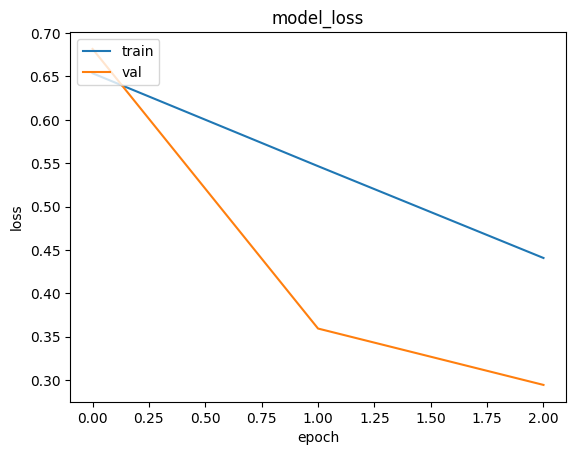

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()